In [103]:
#plots
import matplotlib.pylab as plt
from pylab import *
from mpl_toolkits.mplot3d import Axes3D
# import seaborn as sns; sns.set()
from matplotlib import colors
from itertools import cycle

#data
import pandas as pd
import numpy as np
from numpy import array
from numpy import argmax
import json
from collections import OrderedDict
from scipy.stats import norm as gauss
import random
from random import shuffle

#ML
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import keras
from keras import objectives
from keras import backend as K
from keras.callbacks import EarlyStopping
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, Multiply, Add, Lambda, Layer
from keras.layers.core import Dense, Activation, Flatten, RepeatVector
from keras.layers.wrappers import TimeDistributed
from keras.layers.recurrent import GRU
from keras.layers.convolutional import Convolution1D
from keras.optimizers import Adam, Nadam
from keras.objectives import binary_crossentropy #objs or losses

#chem
from rdkit import Chem
from rdkit.Chem import AllChem as Chem
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import DataStructs
from rdkit.Chem import Draw
from rdkit.Chem import MACCSkeys
import salty

#misc/scripts
import sys
sys.path.insert(0, '../')
from scripts import *

vae_models = ['Bootstrap_250k_Cation_1.h5', 'Bootstrap_1Mil_Cation_1.h5',
    '1Mil_GDB17.h5', '1Mil_GDB17_split_500k.h5', '1Mil_GDB17_split_500k_cation_500k.h5']

vae_models = ['M1.h5', 'M2.h5', 'M3.h5', 'M4.h5', 'M5.h5']

#search with single seed data
df1 = pd.read_csv('../data/structure_search_results/vae_1_structures.csv')
df2 = pd.read_csv('../data/structure_search_results/vae_2_structures.csv')
df3 = pd.read_csv('../data/structure_search_results/vae_3_structures.csv')
df4 = pd.read_csv('../data/structure_search_results/vae_4_structures.csv')
df5 = pd.read_csv('../data/structure_search_results/vae_5_structures.csv')
dfs = [df1, df2, df3, df4, df5]

#salt data
cations = pd.read_csv('../data/cations.csv')
cations = cations['smiles_string']
salts = pd.read_csv('../data/salts.csv')
salts = salts['smiles_string']
categories = pd.read_csv('../data/categories.csv')
categories = categories['category']
coldic = pd.read_csv('../data/coldic.csv')
coldic = coldic.to_dict(orient='records')[0]
salt_coldic = pd.read_csv('../data/salt_coldic.csv')
salt_coldic = salt_coldic.to_dict(orient='records')[0]
salt_categories = pd.read_csv('../data/salt_categories.csv')
salt_categories = salt_categories['category']

In [104]:
from rdkit.ML.Descriptors.MoleculeDescriptors import\
    MolecularDescriptorCalculator as calculator
from sklearn.preprocessing import StandardScaler
from numpy import log
from keras.layers import Dense, Dropout, Input
from keras.models import Model, Sequential
from keras.optimizers import Nadam
from keras.callbacks import EarlyStopping

from numpy import array
from keras.models import load_model
from os.path import dirname, join
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.six import iteritems
from matplotlib.lines import Line2D
from matplotlib.patches import Polygon
from matplotlib.pyplot import figure
from rdkit.Chem.Draw.canvasbase import CanvasBase
from rdkit.Chem.Draw.MolDrawing import MolDrawing, DrawingOptions
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 8}

matplotlib.rc('font', **font)
from scipy.constants import golden as phi

def raad(y_true, y_pred):
    return np.sum(np.abs((y_pred-y_true)/y_true))/len(y_true)*100

class Canvas(CanvasBase):

  def __init__(self, size, name='', imageType='png'):
    self._name = name
    self.size = size
    dpi = max(size[0], size[1])
    figsize = (int(float(size[0]) / dpi), int(float(size[1]) / dpi))
    self._figure = figure(figsize=figsize)
    self._axes = self._figure.add_axes([0, 0, 2.5, 2.5])
    self._axes.set_xticklabels('')
    self._axes.set_yticklabels('')
    self._axes.get_xaxis().set_visible(False)
    self._axes.get_yaxis().set_visible(False)
    self._dpi = dpi

  def rescalePt(self, p1):
    return [float(p1[0]) / self._dpi, float(self.size[1] - p1[1]) / self._dpi]

  def addCanvasLine(self, p1, p2, color=(0, 0, 0), color2=None, **kwargs):
    canvas = self._axes
    p1 = self.rescalePt(p1)
    p2 = self.rescalePt(p2)
    if color2 and color2 != color:
      mp = (p1[0] + p2[0]) / 2., (p1[1] + p2[1]) / 2.
      canvas.add_line(Line2D((p1[0], mp[0]), (p1[1], mp[1]), color=color, **kwargs))
      canvas.add_line(Line2D((mp[0], p2[0]), (mp[1], p2[1]), color=color2, **kwargs))
    else:
      canvas.add_line(Line2D((p1[0], p2[0]), (p1[1], p2[1]), color=color, **kwargs))
    
  def addCanvasPolygon(self, ps, color=(0, 0, 0), **kwargs):
    canvas = self._axes
    ps = [self.rescalePt(x) for x in ps]
    canvas.add_patch(Polygon(ps, linewidth=0, facecolor=color))
  def addCanvasText(self, text, pos, font, color=(0, 0, 0), **kwargs):
    import re
    pos = self.rescalePt(pos)
    canvas = self._axes
    text = re.sub(r'<.*?>', '', text)
    orientation = kwargs.get('orientation', 'E')
    halign = 'center'
    valign = 'center'
    if orientation == 'E':
      halign = 'left'
    elif orientation == 'W':
      halign = 'right'
    elif orientation == 'S':
      valign = 'top'
    elif orientation == 'N':
      valign = 'bottom'

    annot = canvas.annotate(text, (pos[0], pos[1]), color=color, verticalalignment=valign,
                            horizontalalignment=halign, weight=font.weight, size=font.size * 2.0,
                            family=font.face)

    try:
      bb = annot.get_window_extent(renderer=self._figure.canvas.get_renderer())
      w, h = bb.width, bb.height
      tw, th = canvas.transData.inverted().transform((w, h))
    except AttributeError:
      tw, th = 0.1, 0.1  # <- kludge
    return (tw, th, 0)

  def addCanvasPolygon(self, ps, color=(0, 0, 0), **kwargs):
    canvas = self._axes
    ps = [self.rescalePt(x) for x in ps]
    canvas.add_patch(Polygon(ps, linewidth=0, facecolor=color))

**Training histories**

In [105]:
vae_models

['M1.h5', 'M2.h5', 'M3.h5', 'M4.h5', 'M5.h5']

In [106]:
chemvae = CationVAE()
f = open("../data/gdb_char_to_index.json", "r")
char_to_index = json.loads(f.read())
char_set = set(char_to_index.keys())
chemvae.create(char_set, max_length=51, weights_file='../models/{}'.format(vae_models[0]), qspr=False)

In [107]:
chemvae.autoencoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 51, 33)       0                                            
__________________________________________________________________________________________________
conv_1 (Conv1D)                 (None, 43, 9)        2682        input_12[0][0]                   
__________________________________________________________________________________________________
conv_2 (Conv1D)                 (None, 35, 9)        738         conv_1[0][0]                     
__________________________________________________________________________________________________
conv_3 (Conv1D)                 (None, 25, 10)       1000        conv_2[0][0]                     
__________________________________________________________________________________________________
flatten_1 

**check model sanity**

In [108]:
#training array info
smile_max_length = 105
import json
f = open("../data/salt_char_to_index.json","r")
char_to_index = json.loads(f.read())
char_set = set(char_to_index.keys())
char_list = list(char_to_index.keys())
chars_in_dict = len(char_list)
index_to_char = dict((i, c) for i, c in enumerate(char_list))

#model
chemvae = MoleculeVAE()
chemvae.create(char_set, max_length=smile_max_length, weights_file='../models/GEN3.h5', qspr=True)

df = pd.read_csv('../data/GDB/GDB17.1000000') #1Mil GDB entries, easy on memory
df.columns = ['smiles']
data_epoch_size = 500
for _epoch in range(1):
    selected = df['smiles'][data_epoch_size*_epoch:data_epoch_size*(_epoch+1)].reset_index(drop=True)
    values = pd.Series(selected.values + '.' + selected[::-1].values)

In [109]:
seed = salts[random.randint(0,len(salts))]
print("seed:\t{}".format(seed))
string = ""
for i in chemvae.autoencoder.predict(one_hot(seed, char_to_index, smile_max_length=105))[:1]:
    if len(i.shape) > 2:
        i = i[0] #for qspr chemvae there is an extra dim
    for j in i:
#         print(j.shape)
        index = sample(j, temperature=0.2)
        string += index_to_char[index]
print("sample:\t{}".format(string))

seed:	CCCCCCCCCCCCn1cc[n+](c1)C.F[P-](F)(F)(F)(F)F
sample:	@lN7oFI)1eF [#Be7r-@H(46rn[++7S(NPc#o 1==n@ScS486oF3 /nn-O7l(s]OP[(187(Io--1(o+[n2leBFl[c28#r=]]\r3I]o8o3


**evolution of the latent space**

*first million training samples*

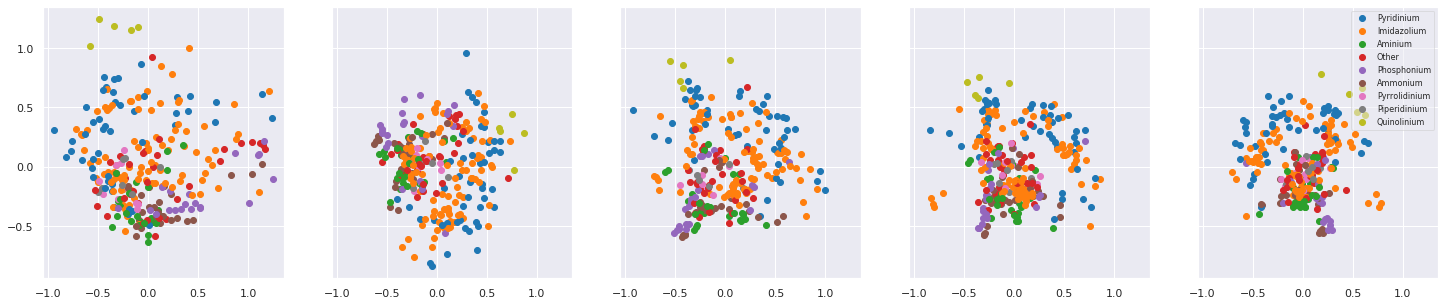

In [110]:
#cation-gdb hybrid models
cation_embeddings_final = np.load('../data/latent_arrays/cation_embeddings_final.npy')
import random
fig, axs = plt.subplots(1,5, figsize=(25,5), sharex=True, sharey=True)
axs = axs.ravel()
colors = my_colors() 
index = 0

for model in range(0,5): #plot of training data only
    z = cation_embeddings_final[model]
    pca = PCA(n_components=2)
    pcs = pca.fit_transform(z)
    for i in range(len(categories)):
        axs[model].plot(pcs[i,0], 
                        pcs[i,1],
                 linestyle='', marker='.', markersize=12,
                    color=coldic[categories[i]], alpha=1, label=categories[i])
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), fontsize=8, framealpha=0.5, frameon=True)

In [111]:
# fig.savefig('assets/final_model_latent.svg', dpi=300)

##### **Sampling in the latent space**

Models

*purist*
* M1: 250K bootstrap C+
* M2: 1000K bootstrap C+
* M3: 1000K GDB

*transfer*
* M4: M3 + 500K GDB/C+
* M5: M4 + 500K C+

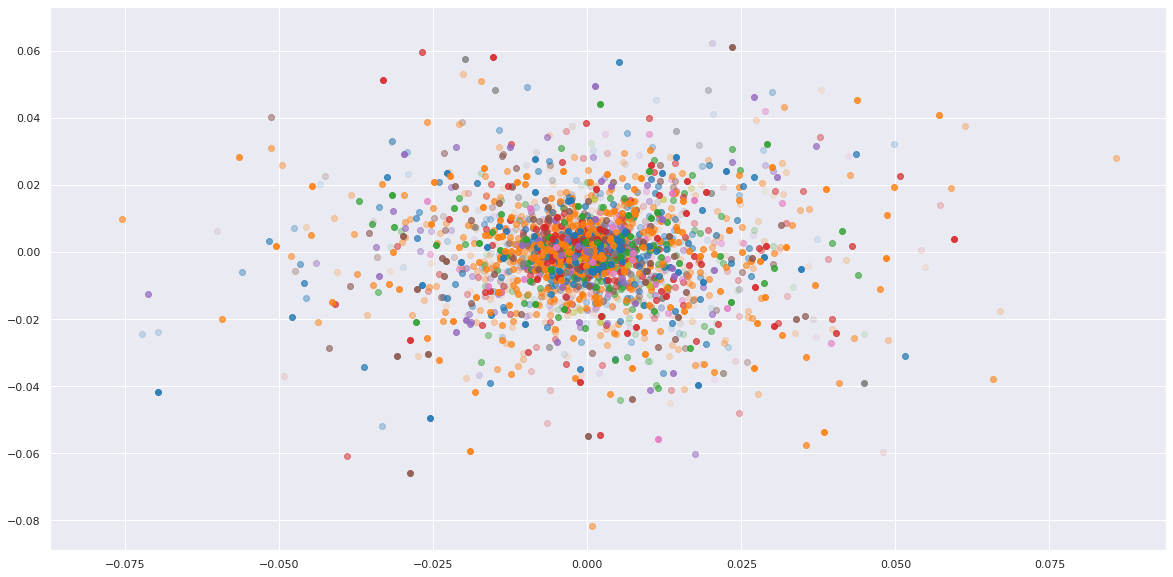

In [112]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(111)
peters_porrige = []
for peter in range(10):
    z = []
    for smi in cations:
        z_i = chemvae.encoder.predict(one_hot(smi, char_to_index))
        z.append(z_i[0])
    z = np.array(z)
    pca = PCA(n_components=2)
    pca.fit_transform(z)
    peters_porrige.append(z)
    for i in range(len(categories)):
        ax1.plot(np.sum(np.dot(pca.components_[0,i],z[i,:])), 
             np.sum(np.dot(pca.components_[1,i],z[i,:])),
            linestyle='', marker='.', color=coldic[categories[i]], markersize=12, label=categories[i], alpha=peter/10)

**we can see the enforced prior in the latent space**

4	 positively charged molecules in M1 w/o C+
4	 positively charged molecules in M2 w/o C+
4	 positively charged molecules in M3 w/o C+
4	 positively charged molecules in M4 w/o C+
4	 positively charged molecules in M5 w/o C+


/home/wbeckner/anaconda3/envs/py37/lib/python3.7/site-packages/pandas/plotting/_core.py:1001: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(left, right)


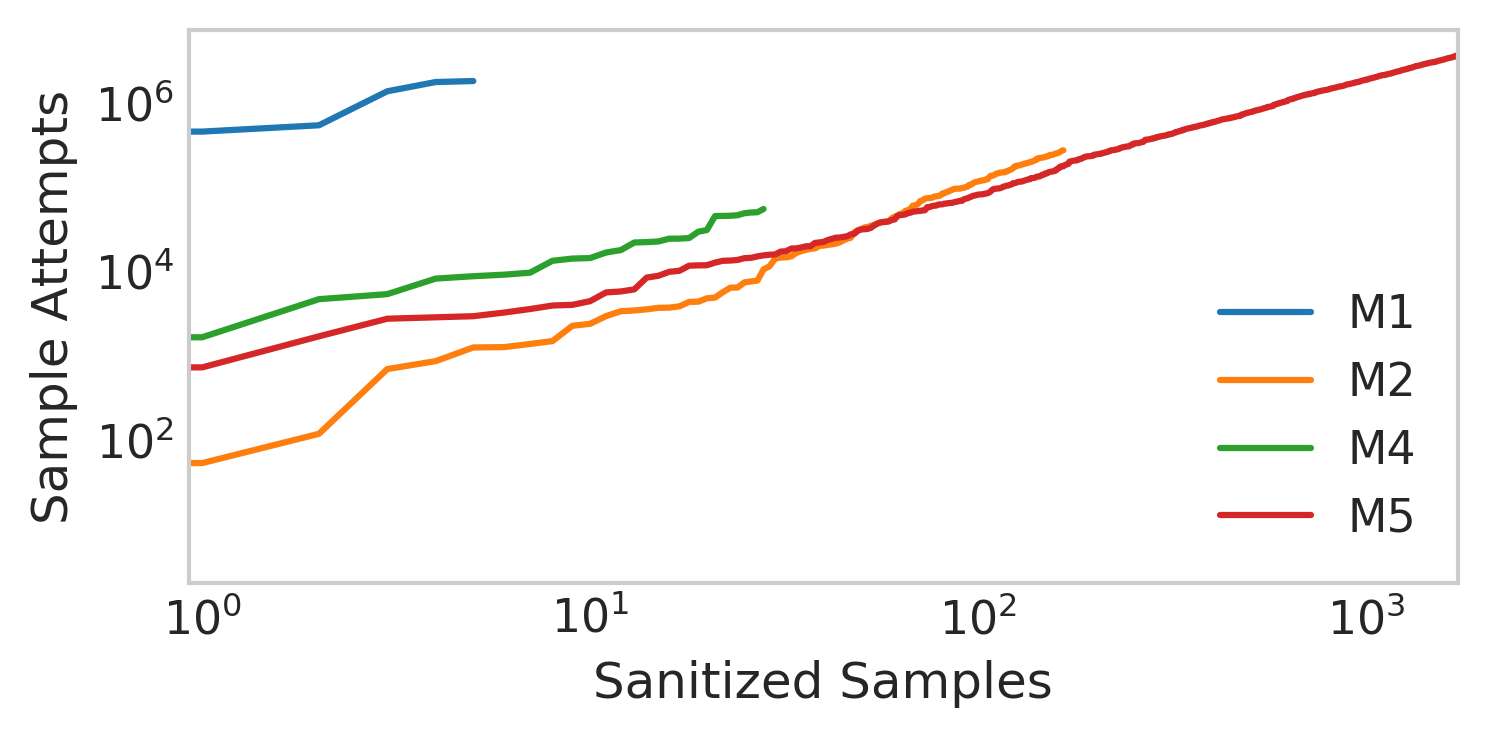

In [113]:
ms = [cations[0], 'CCCC[C+]1C=CC(C)=C1C', 'CCCC[C+]1C=CC(CC)=C1', cations[2]]
ms = [Chem.MolFromSmiles(smi) for smi in ms]
with plt.style.context('seaborn-whitegrid'):
    fig = plt.figure(figsize=(5,2.5), dpi=300)
    ax = fig.add_subplot(111)
    tab = my_colors()
#     for i, df in enumerate(dfs): #for all returns in dfs
    ###start positive version
    for i, df in enumerate(dfs): #only for (+) mols w/o C+ in dataset
        df = df[df['smiles'].str.contains("\+")] 
        df.reset_index(inplace=True)
        print('{}\t positively charged molecules in M{} w/o C+'.format(len(ms),i+1))
        if df.shape[0] == 0:
            continue
        #end positive version
        df['iteration'].plot(label='M{}'.format(i+1), ax=ax, loglog=True, color=next(tab))
    ax.set_ylabel('Sample Attempts')
    ax.set_xlabel('Sanitized Samples')
    plt.legend()
    plt.grid()
    plt.tight_layout()

/home/wbeckner/anaconda3/envs/py37/lib/python3.7/site-packages/pandas/plotting/_core.py:2477: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  ax.hist(values, bins=bins, **kwds)


Text(-0.6, -0.5, 'Temperature')

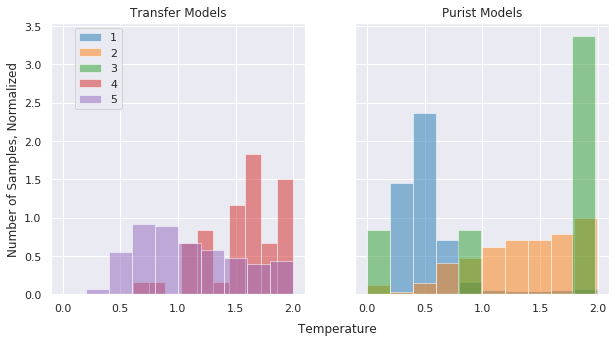

In [114]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5), sharey=True, sharex=True)
tab = my_colors()
for index, df in enumerate(dfs):
    if index < 3:
        df['temperature'].hist(alpha=0.5, label='{}'.format(index+1), normed=True, ax=ax2, color=next(tab))
    else:
        df['temperature'].hist(alpha=0.5, label='{}'.format(index+1), normed=True, ax=ax1, color=next(tab))
h1, l1 = ax2.get_legend_handles_labels()
h2, l2 = ax1.get_legend_handles_labels()
plt.legend(h1+h2, l1+l2, bbox_to_anchor=(-0.9,1))
ax1.set_ylabel('Number of Samples, Normalized')
ax1.set_title('Transfer Models')
ax2.set_title('Purist Models')
plt.text(-0.6,-0.5,'Temperature',size=12)

In [115]:
def draw(smiles, size=(300, 300), kekulize=True, wedgeBonds=True, imageType=None, fitImage=False, options=None, **kwargs):
    """
    draw smiles to notebook with RDKit
    
    and without those dumb matplotlib ticks
    
    ¯\_(ツ)_/¯
    
    """
    canvas = Canvas(size)
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.Mol(mol.ToBinary())
    Chem.Kekulize(mol)
    AllChem.Compute2DCoords(mol)
    drawer = MolDrawing(canvas=canvas)
    omol = mol
    drawer.AddMol(mol)
    omol._atomPs = drawer.atomPs[mol]
    for k, v in iteritems(omol._atomPs):
        omol._atomPs[k] = canvas.rescalePt(v)
    canvas._figure.set_size_inches(float(size[0]) / 100, float(size[1]) / 100)
    canvas._figure
    return canvas._figure

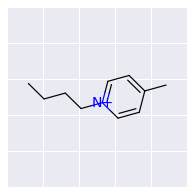

In [116]:
seed = Chem.MolFromSmiles('CCCC[n+]1ccc(cc1)C')
fig = Draw.MolToMPL(seed,size=(100,100))

In [117]:
# seed_img.savefig('assets/cation_seed.png', dpi=300)

In [118]:
seed = Chem.MolFromSmiles('CCCC[n+]1ccc(cc1)C')
for df in dfs:
    daylight = []
    maccs = []
    for mol in df['smiles']:
        ms = [seed, Chem.MolFromSmiles(mol)]
        fps_maccs = [MACCSkeys.GenMACCSKeys(x) for x in ms]
        fps_daylight = [FingerprintMols.FingerprintMol(x) for x in ms]
#         fps = [Chem.rdmolops.RDKFingerprint(x, useHs=False, maxPath=7) for x in ms]
        daylight.append(DataStructs.FingerprintSimilarity(fps_daylight[0],fps_daylight[1]))
        maccs.append(DataStructs.FingerprintSimilarity(fps_maccs[0],fps_maccs[1]))
    df['maccs'] = maccs
    df['daylight'] = daylight

Text(-0.67, -2, 'Daylight Fingerprint Tanimoto Similarity')

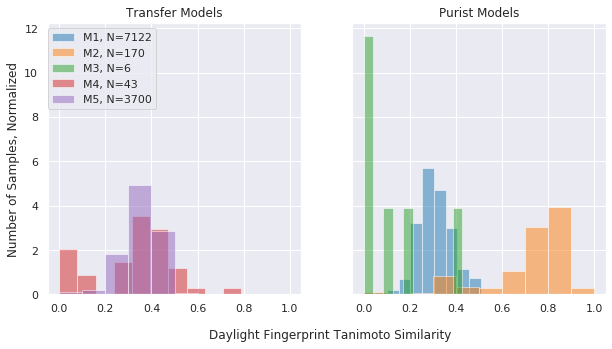

In [119]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5), sharey=True, sharex=True)
tab = my_colors()
for index, df in enumerate(dfs):
    if index < 3:
        df['daylight'].hist(alpha=0.5, label='M{}, N={}'.format(index+1,df.shape[0]), normed=True, ax=ax2, color=next(tab))
    else:
        df['daylight'].hist(alpha=0.5, label='M{}, N={}'.format(index+1,df.shape[0]), normed=True, ax=ax1, color=next(tab))
h1, l1 = ax2.get_legend_handles_labels()
h2, l2 = ax1.get_legend_handles_labels()
plt.legend(h1+h2, l1+l2, bbox_to_anchor=(-0.75,1))
ax1.set_ylabel('Number of Samples, Normalized')
ax1.set_title('Transfer Models')
ax2.set_title('Purist Models')
plt.text(-0.67,-2,'Daylight Fingerprint Tanimoto Similarity',size=12)

2	 positively charged molecules in M1 w/o C+
2	 positively charged molecules in M2 w/o C+
2	 positively charged molecules in M3 w/o C+
2	 positively charged molecules in M4 w/o C+
2	 positively charged molecules in M5 w/o C+


/home/wbeckner/anaconda3/envs/py37/lib/python3.7/site-packages/pandas/plotting/_core.py:2477: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  ax.hist(values, bins=bins, **kwds)


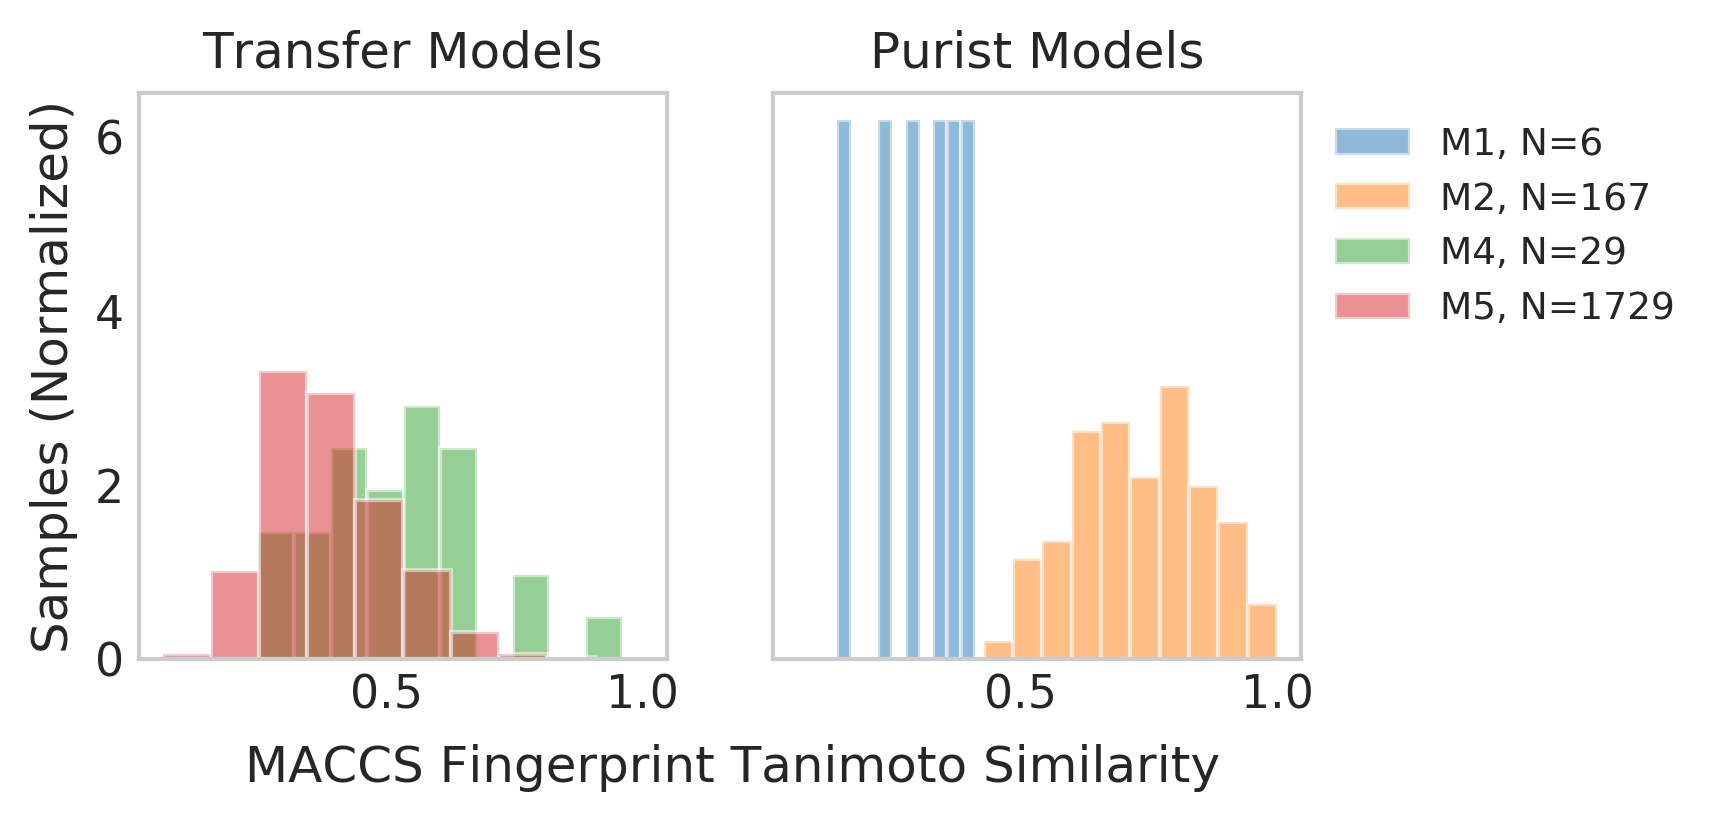

In [120]:
with plt.style.context('seaborn-whitegrid'):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5,2.5), sharey=True, sharex=True, dpi=300)
    tab = my_colors()
        
    for index, df in enumerate(dfs):
        df = df[df['smiles'].str.contains("\+")] 
        df.reset_index(inplace=True)
        print('{}\t positively charged molecules in M{} w/o C+'.format(len(ms),index+1))
        if df.shape[0] == 0:
            continue
        if index < 3:
            df['maccs'].hist(alpha=0.5, label='M{}, N={}'.format(index+1,df.shape[0]), normed=True, ax=ax2, color=next(tab))
        else:
            df['maccs'].hist(alpha=0.5, label='M{}, N={}'.format(index+1,df.shape[0]), normed=True, ax=ax1, color=next(tab))
    h1, l1 = ax2.get_legend_handles_labels()
    h2, l2 = ax1.get_legend_handles_labels()
    plt.legend(h1+h2, l1+l2, fontsize=9, bbox_to_anchor=(1,1))
    ax1.set_ylabel('Samples (Normalized)')
    ax1.set_title('Transfer Models')
    ax2.set_title('Purist Models')
    label = ax1.set_xlabel('MACCS Fingerprint Tanimoto Similarity', fontsize = 12)
    ax1.xaxis.set_label_coords(1.125, -0.15)
#     plt.text(-1,-4,'MACCS Fingerprint Tanimoto Similarity',size=12)
    ax1.grid()
    ax2.grid()
#     plt.tight_layout()

In [121]:
fig.savefig('assets/maccs_cation_samples_distributions_positive.svg', bbox_inches='tight', dpi=300)

**But how many of these structures are relevant?**

In [122]:
for i, df in enumerate(dfs):
    ms = [Chem.MolFromSmiles(smi) for smi in df['smiles'] if '+' in smi]    
    print('{}\t positively charged molecules in M{}'.format(len(ms),i+1))
print('')
for i, df in enumerate(dfs):
    ms = [smi for smi in df['smiles'] if '+' in smi]    
    ms = [smi for smi in ms if 'C+' not in smi]
    ms = [smi for smi in ms if 'c+' not in smi]
    print('{}\t positively charged molecules in M{} w/o C+'.format(len(ms),i+1))
print('')
for i, df in enumerate(dfs):
    ms = [Chem.MolFromSmiles(smi) for smi in pd.merge(df5, df, how='inner', on='smiles')['smiles']]
    print('{}\t structures shared by M5 and M{}'.format(len(ms),i+1))

6	 positively charged molecules in M1
167	 positively charged molecules in M2
0	 positively charged molecules in M3
29	 positively charged molecules in M4
1729	 positively charged molecules in M5

0	 positively charged molecules in M1 w/o C+
167	 positively charged molecules in M2 w/o C+
0	 positively charged molecules in M3 w/o C+
28	 positively charged molecules in M4 w/o C+
807	 positively charged molecules in M5 w/o C+

94	 structures shared by M5 and M1
9	 structures shared by M5 and M2
4	 structures shared by M5 and M3
11	 structures shared by M5 and M4
3700	 structures shared by M5 and M5


M1 sample of + structures


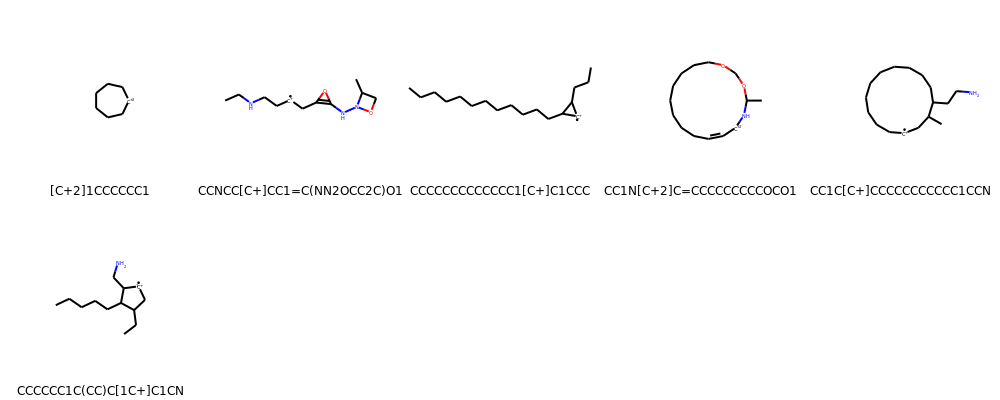

In [123]:
ms = [Chem.MolFromSmiles(smi) for smi in df1['smiles'] if '+' in smi]
print('M1 sample of + structures')
fig = Draw.MolsToGridImage(ms[:10],molsPerRow=5,subImgSize=(200,200),legends=[Chem.MolToSmiles(x) for x in ms[:50]])
fig.save('assets/m1_example_structures.png')
fig

M5 sample of + structures


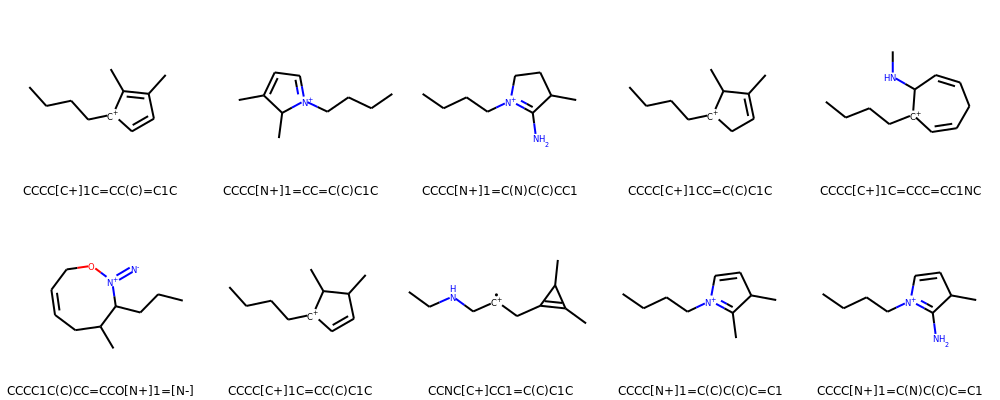

In [124]:
ms = [Chem.MolFromSmiles(smi) for smi in df5['smiles'] if '+' in smi]
print('M5 sample of + structures')
fig = Draw.MolsToGridImage(ms[:10],molsPerRow=5,subImgSize=(200,200),legends=[Chem.MolToSmiles(x) for x in ms[:50]])
fig.save('assets/m5_example_structures.png')
fig

M2 sample of + structures


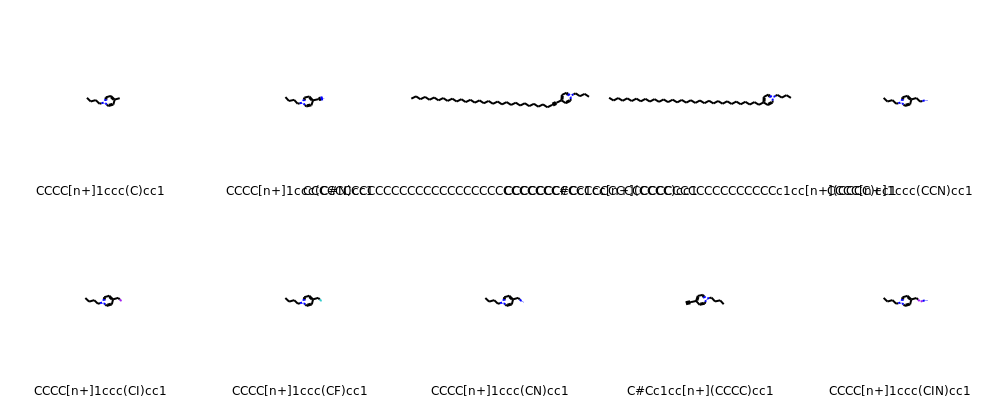

In [125]:
ms = [Chem.MolFromSmiles(smi) for smi in df2['smiles'] if '+' in smi]
print('M2 sample of + structures')
fig = Draw.MolsToGridImage(ms[:10],molsPerRow=5,subImgSize=(200,200),legends=[Chem.MolToSmiles(x) for x in ms[:50]])
fig.save('assets/m2_example_structures.png')
fig

M4 sample of + structures


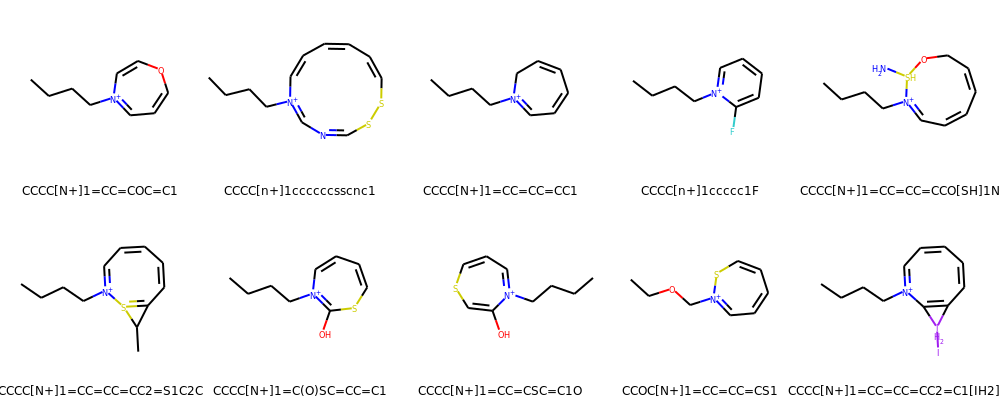

In [126]:
ms = [Chem.MolFromSmiles(smi) for smi in df4['smiles'] if '+' in smi]
print('M4 sample of + structures')
fig = Draw.MolsToGridImage(ms[:10],molsPerRow=5,subImgSize=(200,200),legends=[Chem.MolToSmiles(x) for x in ms[:50]])
fig.save('assets/m4_example_structures.png')
fig

94 structures shared by M5 and M1


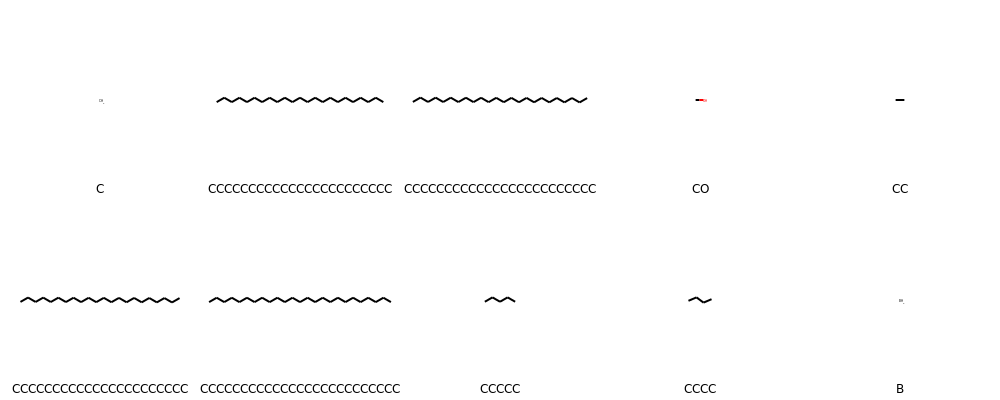

In [127]:
ms = [Chem.MolFromSmiles(smi) for smi in pd.merge(df1, df5, how='inner', on='smiles')['smiles']]
print('{} structures shared by M5 and M1'.format(len(ms)))
Draw.MolsToGridImage(ms[:10],molsPerRow=5,subImgSize=(200,200),legends=[Chem.MolToSmiles(x) for x in ms[:]])

11 structures shared by M5 and M4


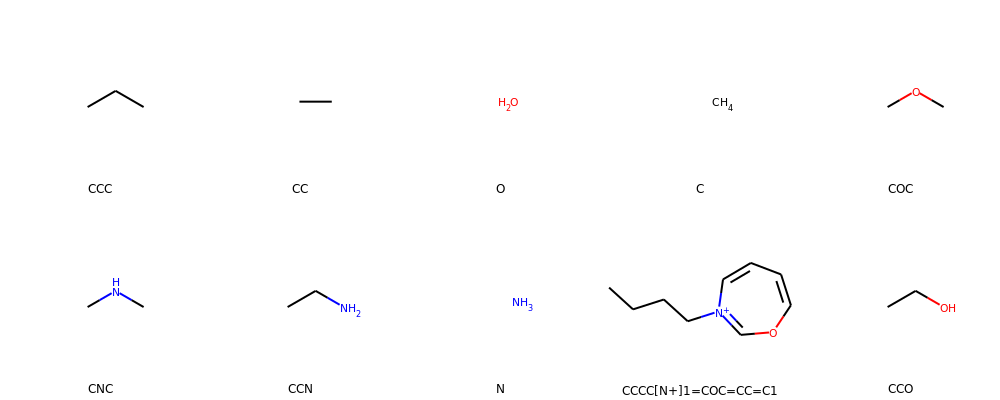

In [128]:
ms = [Chem.MolFromSmiles(smi) for smi in pd.merge(df4, df5, how='inner', on='smiles')['smiles']]
print('{} structures shared by M5 and M4'.format(len(ms)))
Draw.MolsToGridImage(ms[:10],molsPerRow=5,subImgSize=(200,200),legends=[Chem.MolToSmiles(x) for x in ms[:]])

9 structures shared by M5 and M2


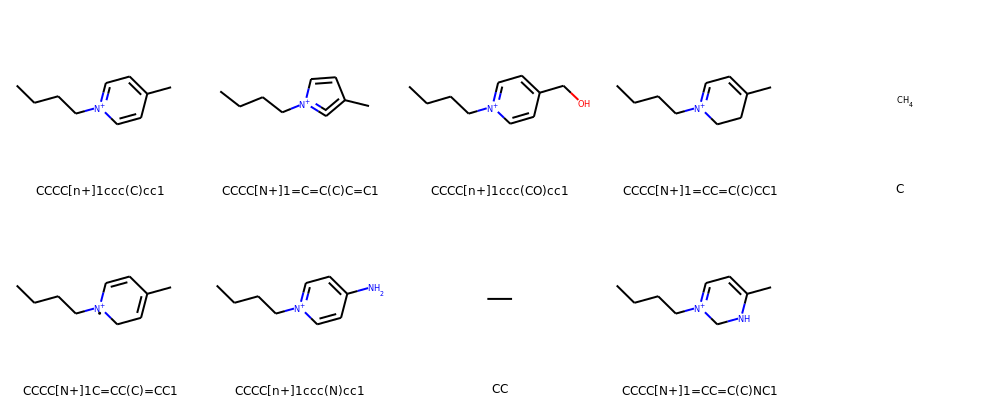

In [129]:
ms = [Chem.MolFromSmiles(smi) for smi in pd.merge(df2, df5, how='inner', on='smiles')['smiles']]
print('{} structures shared by M5 and M2'.format(len(ms)))
Draw.MolsToGridImage(ms[:10],molsPerRow=5,subImgSize=(200,200),legends=[Chem.MolToSmiles(x) for x in ms[:]])